In [410]:
from music21 import converter, corpus, instrument, midi, note, chord, pitch
import os
import seaborn as snb

In [411]:
def open_midi(midi_path, remove_drums):
    # There is an one-line method to read MIDIs
    # but to remove the drums we need to manipulate some
    # low level MIDI events.
    mf = midi.MidiFile()
    mf.open(midi_path)
    mf.read()
    mf.close()
    if (remove_drums):
        for i in range(len(mf.tracks)):
            mf.tracks[i].events = [ev for ev in mf.tracks[i].events if ev.channel != 10]          

    return midi.translate.midiFileToStream(mf)

def concat_path(path, child):
    return path + "/" + child

In [412]:
from music21 import roman

def note_count(measure, count_dict):
    bass_note = None
    for chord in measure.recurse().getElementsByClass('Chord'):
        # All notes have the same length of its chord parent.
        note_length = chord.quarterLength
        for note in chord.pitches:          
            # If note is "C5", note.name is "C". We use "C5"
            # style to be able to detect more precise inversions.
            note_name = str(note) 
            if (bass_note is None or bass_note.ps > note.ps):
                bass_note = note
                
            if note_name in count_dict:
                count_dict[note_name] += note_length
            else:
                count_dict[note_name] = note_length
        
    return bass_note
                
def simplify_roman_name(roman_numeral):
    # Chords can get nasty names as "bII#86#6#5",
    # in this method we try to simplify names, even if it ends in
    # a different chord to reduce the chord vocabulary and display
    # chord function clearer.
    ret = roman_numeral.romanNumeral
    inversion_name = None
    inversion = roman_numeral.inversion()
    
    # Checking valid inversions.
    if ((roman_numeral.isTriad() and inversion < 3) or
            (inversion < 4 and
                 (roman_numeral.seventh is not None or roman_numeral.isSeventh()))):
        inversion_name = roman_numeral.inversionName()
        
    if (inversion_name is not None):
        ret = ret + str(inversion_name)
        
    elif (roman_numeral.isDominantSeventh()): ret = ret + "M7"
    elif (roman_numeral.isDiminishedSeventh()): ret = ret + "o7"
    return ret
                
def harmonic_reduction(midi_file):
    ret = []
    temp_midi = stream.Score()
    temp_midi_chords = midi_file.chordify()
    temp_midi.insert(0, temp_midi_chords)    
    music_key = temp_midi.analyze('key')
    max_notes_per_chord = 4   
    for m in temp_midi_chords.measures(0, None): # None = get all measures.
        if (type(m) != stream.Measure):
            continue
        
        # Here we count all notes length in each measure,
        # get the most frequent ones and try to create a chord with them.
        count_dict = dict()
        bass_note = note_count(m, count_dict)
        if (len(count_dict) < 1):
            ret.append("-") # Empty measure
            continue
        
        sorted_items = sorted(count_dict.items(), key=lambda x:x[1])
        sorted_notes = [item[0] for item in sorted_items[-max_notes_per_chord:]]
        measure_chord = chord.Chord(sorted_notes)
        
        # Convert the chord to the functional roman representation
        # to make its information independent of the music key.
        roman_numeral = roman.romanNumeralFromChord(measure_chord, music_key)
        ret.append(simplify_roman_name(roman_numeral))
        
    return ret

#harmonic_reduction(base_midi)[0:10]

In [413]:
import re
import os
import pandas as pd

In [449]:
with open("./output/classical_150_it_100_songs/store/train.txt","r",encoding="utf-8") as f:
    data = [f'./data/classical/{j}' for j in f.read().split("\n")]

In [450]:
target_games = data[0:80]
df_array = []
for i in target_games:
    elemento = open_midi(i,True)
    df_array.append({'midi_name':os.path.basename(i),'coef':float(elemento.analyze('key').correlationCoefficient), 'key_signature': str(elemento.analyze('key')),'harmonic_reduction':harmonic_reduction(elemento)})
sonic_df = pd.DataFrame(df_array)
sonic_df.head()

/usr/local/lib/python3.9/dist-packages/music21/midi/translate.py:785: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=14, channel=None, data=b'Sequenced by Ken Whitcomb \xa91998'>; getting generic Instrument
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/music21/midi/translate.py:785: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=2, channel=None, data=b'Les Soir\xe9es de Nazelles II'>; getting generic Instrument
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/music21/midi/translate.py:785: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, channel=None, data=b"L'Arl\xe9sienne, suite 2 (1875), 3. Menuett">; getting generic Instrument
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/music21/midi/translate.py:785: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQU

,midi_name,coef,key_signature,harmonic_reduction
0,chno5501.mid,0.804323,f minor,"[v, i43, v42, i43, v42, i43, iv, V42, i7, i43,..."
1,32brithsc3.mid,0.854015,a minor,"[-, i, v, #vi65, ii42, vii, I, bVII, ii42, V53..."
2,2079melody3Steven.mid,0.858888,E major,"[I6, I6, I64, vi42, iv, IV64, I53, I53, ii, ii..."
3,727hmmtop95.mid,0.785764,d minor,"[-, -, -, -, iv53, #vi65, #vii, i, iv53, iv53,..."
4,2342cr01c.mid,0.955097,C major,"[I53, i, vi65, iii, vii, vii, V, V42, I42, I, ..."


In [451]:
import gensim, logging
model = gensim.models.Word2Vec(sonic_df["harmonic_reduction"], min_count=2, window=4)

/usr/local/lib/python3.9/dist-packages/gensim/models/base_any2vec.py:742: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  warnings.warn(


In [453]:
sonic_df ["name"] = [f"a_{i}" for i in range(0,80)]
sonic_df

,midi_name,coef,key_signature,harmonic_reduction,name
0,chno5501.mid,0.804323,f minor,"[v, i43, v42, i43, v42, i43, iv, V42, i7, i43,...",a_0
1,32brithsc3.mid,0.854015,a minor,"[-, i, v, #vi65, ii42, vii, I, bVII, ii42, V53...",a_1
2,2079melody3Steven.mid,0.858888,E major,"[I6, I6, I64, vi42, iv, IV64, I53, I53, ii, ii...",a_2
3,727hmmtop95.mid,0.785764,d minor,"[-, -, -, -, iv53, #vi65, #vii, i, iv53, iv53,...",a_3
4,2342cr01c.mid,0.955097,C major,"[I53, i, vi65, iii, vii, vii, V, V42, I42, I, ...",a_4
...,...,...,...,...,...
75,chno2701.mid,0.723437,c# minor,"[-, i, i, i, bIV, bii43, i42, i53, bIV, bii43,...",a_75
76,2658tmsk1301.mid,0.352042,C major,"[#i, ii7, vii, III, #iv65, vii, IV42, iii, #iv...",a_76
77,rach1-3.mid,0.723180,F# major,"[bIII, bi, v, bi, bIII, i, bVII7, iv, bVI43, i...",a_77
78,439symph2-2.mid,0.721177,B major,"[v, v, v, i, iv, iv, biv, ii42, i, vi, ii7, iv...",a_78


In [455]:
import pprint
import numpy as np

def vectorize_harmony(model, harmonic_reduction):
    # Gets the model vector values for each chord from the reduction.
    word_vecs = []
    for word in harmonic_reduction:
        try:
            vec = model[word]
            word_vecs.append(vec)
        except KeyError:
            # Ignore, if the word doesn't exist in the vocabulary
            pass
    
    # Assuming that document vector is the mean of all the word vectors.
    return np.mean(word_vecs, axis=0)

def cosine_similarity(vecA, vecB):
    # Find the similarity between two vectors based on the dot product.
    csim = np.dot(vecA, vecB) / (np.linalg.norm(vecA) * np.linalg.norm(vecB))
    if np.isnan(np.sum(csim)):
        return 0
    
    return csim

def calculate_similarity_aux(df, model, source_name, target_names=[], threshold=0):
    source_harmo = df[df["name"] == source_name]["harmonic_reduction"].values[0]
    source_vec = vectorize_harmony(model, source_harmo)    
    results = []
    for name in target_names:
        target_harmo = df[df["name"] == name]["harmonic_reduction"].values[0]
        if (len(target_harmo) == 0):
            continue
            
        target_vec = vectorize_harmony(model, target_harmo)       
        sim_score = cosine_similarity(source_vec, target_vec)
        if sim_score > threshold:
            results.append({
                'score' : sim_score,
                'name' : name
            })
                
    # Sort results by score in desc order
    results.sort(key=lambda k : k['score'] , reverse=True)
    return results

def calculate_similarity(df, model, source_name, target_prefix, threshold=0):
    source_midi_names = df[df["name"] == source_name]["name"].values
    if (len(source_midi_names) == 0):
        print("Invalid source name")
        return
    
    source_midi_name = source_midi_names[0]
    
    target_midi_names = df[df["name"].str.startswith(target_prefix)]["name"].values  
    if (len(target_midi_names) == 0):
        print("Invalid target prefix")
        return
    
    return calculate_similarity_aux(df, model, source_midi_name, target_midi_names, threshold)

data = []
index = []
for elemento in sonic_df["name"]:
    index.append(elemento)
    data.append(np.array([j["score"] for j in calculate_similarity(sonic_df, model, elemento, "a")]).mean())

/tmp/ipykernel_360447/4064539832.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vec = model[word]


In [456]:
from metricsGAN import get_polyphony_score, get_midi_pattern, get_tones

def info_tones(midi_pattern):
  tones = get_tones(midi_pattern)
  stats = {}
  stats['num_tones'] = len(tones)
  stats['tone_min'] = min(tones)
  stats['tone_max'] = max(tones)
  stats['tone_span'] = max(tones)-min(tones)
  stats['tones_unique'] = len(set(tones))
  return stats

poly_score = [get_polyphony_score(get_midi_pattern(file)) for file in target_games]
tones_music = [info_tones(get_midi_pattern(file)) for file in target_games]

In [ ]:
df = pd.DataFrame(list(zip(sonic_df["midi_name"],data,poly_score)),columns=["music","similitud","polifonia"]).set_index("music")
df2 = pd.DataFrame(tones_music,index=sonic_df["midi_name"])
df = pd.merge(df,df2,how='outer',left_index=True,right_index=True)
del df2
df["resultado"] = (df["similitud"]/df["polifonia"])*(df["tone_span"]/df["tones_unique"])
df = pd.merge(df,sonic_df.set_index("midi_name")["key_signature"],how='outer',left_index=True,right_index=True)
df = df.sort_values(by=['resultado'])
df

In [ ]:
df["resultado2"] = df["similitud"]*sonic_df.set_index(df.index)["coef"] +df["polifonia"]*(df["tone_span"]/df["tone_span"].max())
df = df.sort_values(by=['resultado2'])
df

<AxesSubplot:>

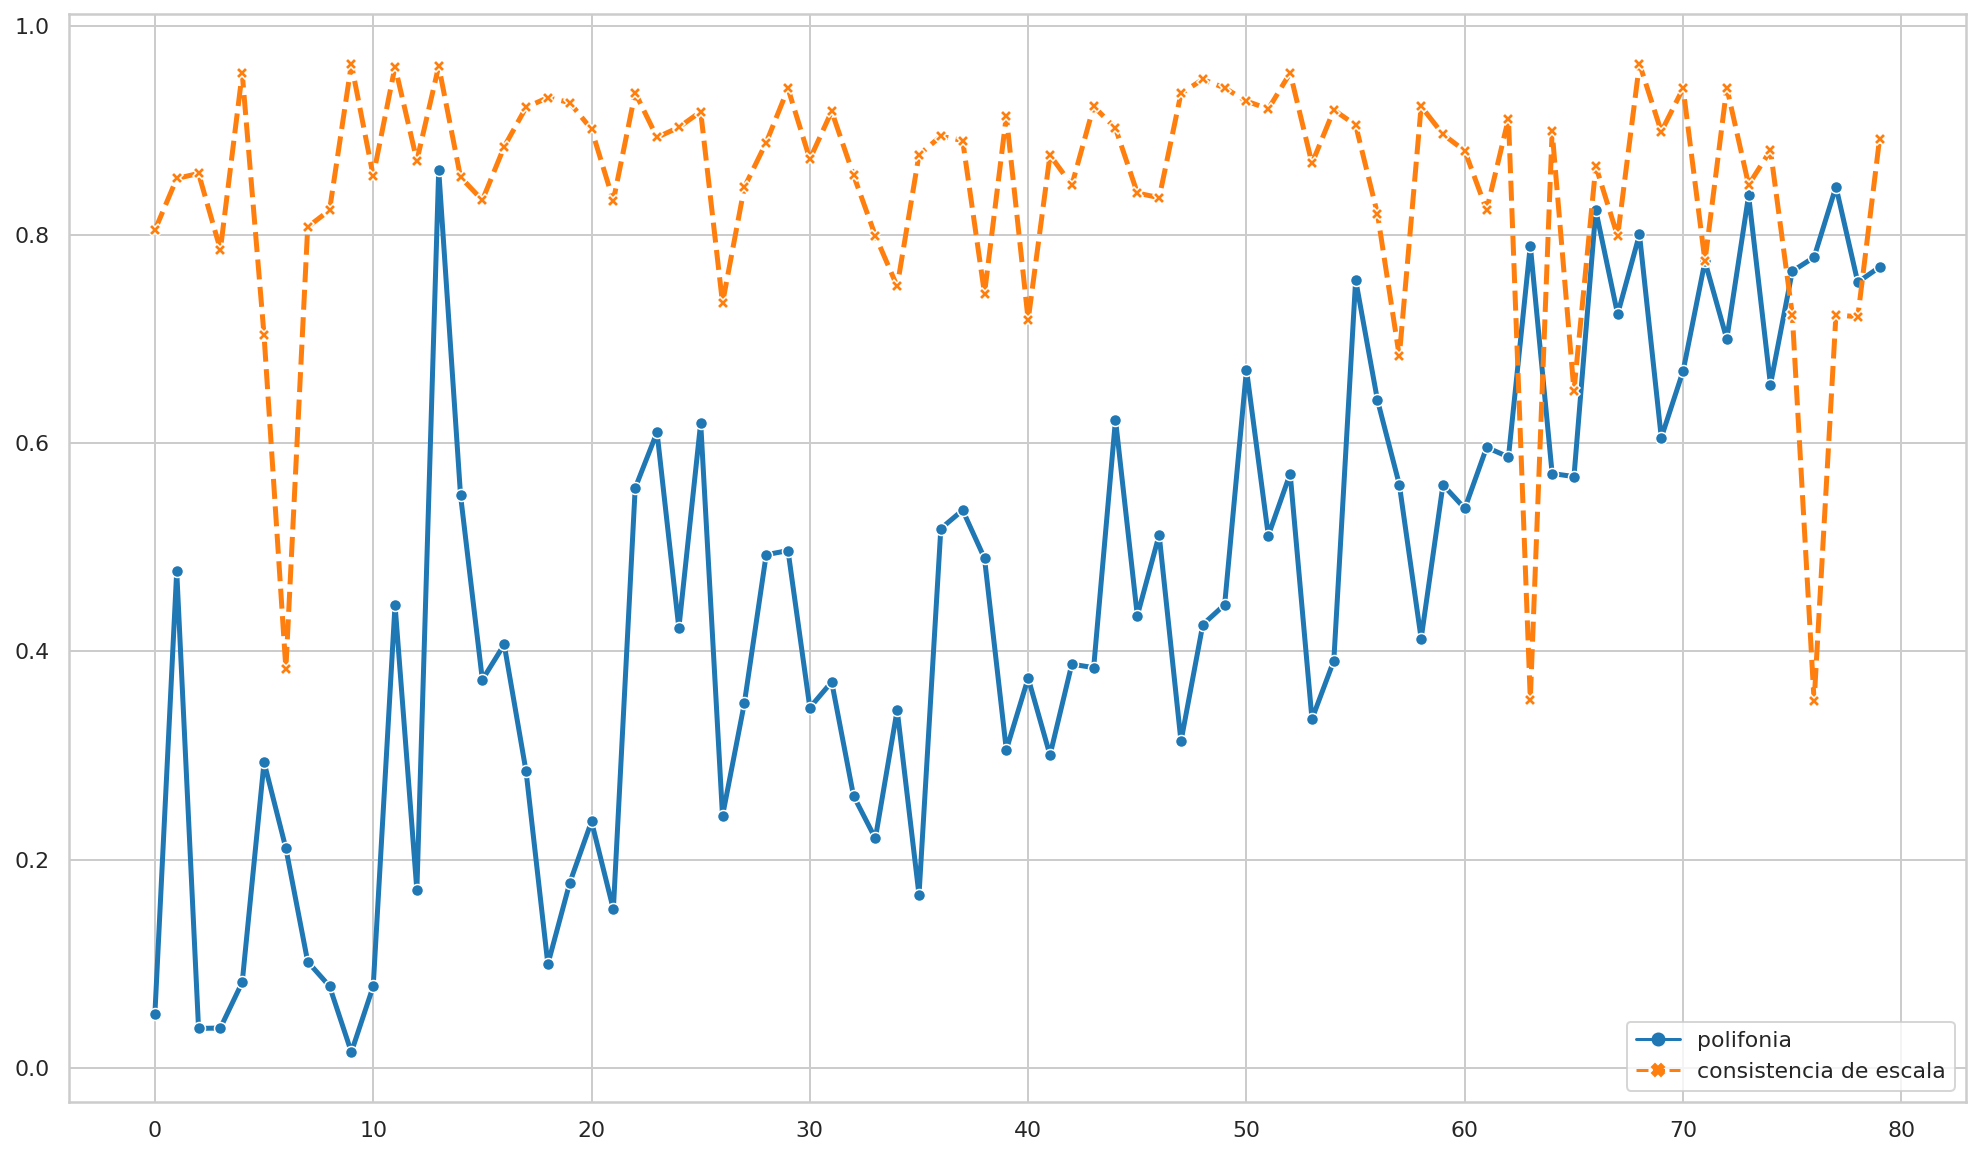

In [473]:
plotdf = df[["polifonia"]]
plotdf = pd.merge(plotdf,sonic_df.set_index(df.index)["coef"],how="inner",right_index=True,left_index=True)
plotdf = plotdf.reset_index()
plotdf["consistencia de escala"] = plotdf["coef"]
del plotdf["coef"]
del plotdf["index"]
plotdf = plotdf.sort_values(by=["polifonia"])
#plotdf["tone_span"] = df["tone_span"]/df["tone_span"].max()
#plotdf = plotdf.sort_values(by=['tone_span'])
plt.figure(figsize=(17,10))
sns.set_theme(style="whitegrid")
sns.lineplot(data=plotdf, palette="tab10", markers = True, linewidth=2.5)